# Course Project – IME692, Fall 2021

## Question

#### Develop  a  predictive  model  in  which  the  dependent variable  isCvdVax_DisparityY.  Your  task  is  to examine  the  role  of  different  socioeconomic and  demographic  variables  indetermining  thecovid-19 vaccination rate disparities. Note following points to complete this project.

(1)You  are  free  to  choose  any prediction/regression model  to  examine  the  role  of  predictors  in determining CvdVax_DisparityY.  But  use  only  data labelledas “train” for the model building purpose. Evaluate the performance ofyourmodels on the test data.

(2)Report three models that give best result on the test dataset. Mentionthe final model that you would select. Explainthe reason for its selection. 

(3)How would you assess the importance of different predictors in your model? Which predictors are most important in determining the racial disparity in covid-19 vaccinate rate? 

(4)Areyour  findings  similar  to  the resultsreported  by  authors  in  Table  1of  the  article  (see  the hyperlink above)? If not, why? 

(5)Upload Python/R code with your project report. 

# programme structure and points

# libraries required

In [48]:
# basic modules
import numpy as np
import pandas as pd

# plot modules
import matplotlib.pyplot as plt
import seaborn as sns

# analysis modules
## pre-process and metrics
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

## linear analysis
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet,ElasticNetCV
from sklearn.linear_model import Ridge,RidgeCV
from sklearn.linear_model import Lasso,LassoCV
import statsmodels.api as sm

## random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

## svm analysis
from sklearn.svm import SVR



# pre-process

### split test-train

- separate independant and dependant variables
- dropped state and county columns 
    - since all variables are numeric except State and County Name

In [49]:
data=pd.read_csv('ime692_project.csv')

# avoid State and County name
cols=data.columns[2:].to_list()
data=data[cols]

# seperate data into test and train based on `Test` indicator
pd.options.mode.chained_assignment = None  # default='warn' --> to supress chain assignment warning <--
test_data=data.loc[data.Test==1] ## previous indices could be useful ##
train_data=data.loc[data.Test==0]

# assert split
print("==========================================")
print("No of testing observations: ",test_data.shape[0])
print("No of training observations: ",train_data.shape[0])
print("==========================================")

# drop the indicator inplace
test_data.drop('Test',axis=1,inplace=True)
train_data.drop('Test',axis=1,inplace=True)

# sepearate predicted and regressor variables
y_test_data=test_data['CvdVax_DisparityY'].tolist()
X_test_data=test_data.drop('CvdVax_DisparityY',axis=1)
y_train_data=train_data['CvdVax_DisparityY'].tolist()
X_train_data=train_data.drop('CvdVax_DisparityY',axis=1)

No of testing observations:  225
No of training observations:  531


### normalization

- z-score normalization is being done on features
    - can work with min-max also
- no need to normalize dependent variable

In [50]:
scalerInst=StandardScaler()
X_train_data_normalized=scalerInst.fit_transform(X_train_data)
X_test_data_normalized=scalerInst.fit_transform(X_test_data)

### Which variables to use(PCA)

- to check which features to use for further analysis
- if small no of features can explain significant variance then work with them only to avoid model becoming complex
    - if not then can not avoid features

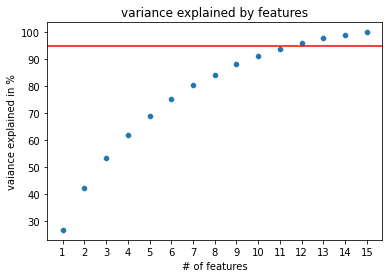

In [51]:
n=X_train_data_normalized.shape[1]
pca=PCA(n_components=n)
X_train_data_transformed=pca.fit_transform(X_train_data_normalized)
X_test_data_transformed=pca.fit_transform(X_test_data_normalized)

foo_ratio=pca.explained_variance_ratio_

# to get cummulative
var_ratio=[]
for i in range(n):
    var_ratio.append(100*sum(foo_ratio[0:i+1]))

# plotting the variance explined curve (in %)
ax=sns.scatterplot(x=np.arange(n)+1,y=var_ratio)
ax.axhline(95,color='red')
plt.title('variance explained by features')
plt.xlabel('# of features')
plt.ylabel('vaiance explained in %')
plt.xticks(np.arange(n)+1)
plt.show() # to avoid text outputs
# plt.savefig('pca.png')


**observations**

- PCA is not a good techniqe for this problem 
    - as no small number set of features explain variance quite significantly
    - if around 5-6 features would have explained around 90-95% variance then PCA would have been helpful, but that is not the case here

# functions for analysis

- function `model` uses test and train data with global scope
- these functions have been used throught the project

### function to plot coef plots for models

**`function parameters:`**
- coefDf: coef data frame with column names from project data
- name: [used as an identifier] name to be printed in plots

In [52]:
def coefplot(coefDf,name):
    # to tweak default barh visual
    kwargs={
    'alpha':0.8,
    'edgecolor':'#333',
    'facecolor':'#eef',
    'width':0.2
    }
    # to plot barh
    (coefDf['Weight of Coeff'].sort_values(ascending = False,kind='mergesort')).plot.barh(figsize=(8,8),**kwargs)
    plt.title(f'Importance of Coeff- {name}')
    plt.xlabel("Importance")
    plt.ylabel('Features')
    plt.show()

### general function for models

**`function parameters:`**
- plot: `Bool`
    - by default is set to `False`, to plot feature coeffs set it to `True`float
- c: `float`
    - tuning hyperparameter used for SVR model, default to 0.1
- kernel: ['linear', 'poly', 'rbf', 'sigmoid']
    - kernel used for SVR model, default to `linear`
- model_title: [used as an identifier]name to be printed in plots etc
- modelName: model `class` name imported from `sklearn`

In [53]:
def model(modelName,model_title,kernel='linear',c=0.1,plot=False,print=False):
    if modelName==SVR:
        rm=modelName(kernel=kernel,C=c)
    else:
        rm=modelName()
    
    rm.fit(X_train_data_normalized,y_train_data)

    # test mse
    preds_test=rm.predict(X_test_data_normalized)
    MSE_test=mean_squared_error(y_test_data,preds_test)

    # train mse
    preds_train=rm.predict(X_train_data_normalized)
    MSE_train=mean_squared_error(y_train_data,preds_train)

    if print==True:
        print(model_title)
        print(''.center(30,'='))
        print('Train MSE =',round(MSE_train,2))
        print('Test MSE =',round(MSE_test,2))
        print(''.center(30,'='))

    if plot==True:
        print('Relative Feature Importance Plot')
        kwargs={
            'alpha':0.8,
            'edgecolor':'#333',
            'facecolor':'#eef',
            'width':0.2
            }
        # to plot barh
        if modelName==RandomForestRegressor:
            coefDf = pd.DataFrame(rm.feature_importances_.T, columns=['Weight of Coeff'], index=X_train_data.columns)
        else:
            coefDf = pd.DataFrame(rm.coef_.T, columns=['Weight of Coeff'], index=X_train_data.columns)
        (coefDf['Weight of Coeff'].sort_values(ascending = False,kind='mergesort')).plot.barh(figsize=(8,8),**kwargs)
        plt.title(f'Importance of Coeff- {model_title}')
        plt.xlabel("Importance")
        plt.ylabel('Features')
        plt.show()

    return {'Model Name':model_title ,'Train':MSE_train,'Test':MSE_test}

In [54]:
# intialize lists to compare models
model_compare=[]
linear_models_compare=[]
# general plotting and printting settings can be changed here
# or one can override these settings in particular function calls
want_to_plot=True
want_to_print=True

# linear model

### normal multiple linear regression

In [55]:
lm=model(LinearRegression,'Normal Linear Regression',plot=want_to_plot,print=want_to_print)
model_compare.append(lm)
linear_models_compare.append(lm)

### restricted regression models

- here restricted models are, specifically: 
    - lasso(l1 norm)
    - ridge(l2 norm)
    - elastinet(l1 and l2 norm)
- we have seen linear model without any restrictions; now to try out this with restrictions we have included these models
- we will compare these models with normal linear model in two cases:
    - first case: with default alpha
    - second case: with best alpha in search space [to see if there is any improvement]

#### model names and titles

In [56]:
models=[
    {
        'title':'Lasso Regression Model',
        'name':Lasso,
        'cv':LassoCV
    },
    {
        'title':'Ridge Regression Model',
        'name':Ridge,
        'cv':RidgeCV
    },
    {
        'title':'Elastinet Regression Model',
        'name':ElasticNet,
        'cv':ElasticNetCV
    }
]

#### func used to cover restrictions linear regression models

**`function params`**

- cvFolds: no of folds to be used to choose best alpha in search space
- title, modelName, modelCV: self-explanatory

In [72]:
# func used to cover with restrictions linear regression models
def restrictModels(title,modelName,modelCV,cvFolds=10,plot=False,print=False):
    # choosing alpha hyperparameter
    ## create search space
    r=np.linspace(-2,5,100)
    alphas=np.power(10*np.ones(100),r)
    ## get best possible alpha in search space
    rcv=modelCV(alphas=alphas,cv=cvFolds)
    rcv.fit(X_train_data_normalized,y_train_data)
    cvAlpha=rcv.alpha_

    # fit model
    rlm=modelName(alpha=cvAlpha)
    rlm.fit(X_train_data_normalized,y_train_data)

    # test mse
    preds_test=rlm.predict(X_test_data_normalized)
    MSE_test=mean_squared_error(y_test_data,preds_test)

    # train mse
    preds_train=rlm.predict(X_train_data_normalized)
    MSE_train=mean_squared_error(y_train_data,preds_train)

    if print:
        # some nice formatting
        print(title)
        print(''.center(30,'='))
        print(f'CV alpha =',round(cvAlpha,2))
        print(f'Train MSE =',round(MSE_train,2))
        print(f'Test MSE =',round(MSE_test,2))
        print(''.center(30,'='))

    if plot:
        # plot
        coefDf = pd.DataFrame(rlm.coef_.T, columns=['Weight of Coeff'], index=X_train_data.columns)
        coefplot(coefDf,title)

    # return data dict
    return {'Model Name':title,'Train':MSE_train,'Test':MSE_test}

#### implementation for comparision[first case]

In [58]:
for m in models:
    linear_models_compare.append(model(m['name'],m['title']+'(first-case)'),plot=want_to_plot,print=want_to_print)

restrictedDf=pd.DataFrame(linear_models_compare)

#### implementation for comparision[second case]

In [73]:
for m in models:
    linear_models_compare.append(restrictModels(m['title']+'(second-case)',m['name'],m['cv']),plot=want_to_plot,print=want_to_print)

restrictedDf=pd.DataFrame(linear_models_compare)

#### Observations

- from below dataframe, it is clear that Lasso(second-case) does slightly better than the Normal linear model
- Lasso (second-case) has no more overfitting problem than normal linear model does
- also we can perform both variable selection and regularization in order to improve the prediction,accuracy and interpretability of the resulting statistical model when using Lasso((least absolute shrinkage and selection operator) Model
- keeping these things in mind we choose **`LASSO MODEL`** out of linear models

In [74]:
restrictedDf

,Model Name,Train,Test
0,Normal Linear Regression,56.266316,68.353944
1,Lasso Regression Model(first-case),67.983229,75.702897
2,Ridge Regression Model(first-case),56.267138,68.370663
3,Elastinet Regression Model(first-case),68.387424,77.608423
4,Lasso Regression Model(second-case),56.268430,68.322285
5,Ridge Regression Model(second-case),57.372207,69.851061
6,Elastinet Regression Model(second-case),56.355681,68.488433
7,Lasso Regression Model(second-case),56.270005,68.312572
8,Ridge Regression Model(second-case),57.232917,69.700699
9,Elastinet Regression Model(second-case),56.392747,68.530688


# Random Forest

In [61]:
rf=model(RandomForestRegressor,'Random Forest',plot=want_to_plot,print=want_to_print)
model_compare.append(rf)

# Support Vector Resgression

In [62]:
svr=model(SVR,'Support Vector Resgression',plot=want_to_plot,print=want_to_print)
model_compare.append(svr)

### tuning hyperparameter(C) in SVR

- till now we have random forest test mse to be lowest but it is overfitting the data as its train mse is much lowwer than test mse.
- to see if SVR outperforms random after tuning `C`(in terms of test mse), we do:
    - work with bunch of different values of `C` and see if any one does better than Random Forest(in terms of test mse)

In [63]:
# optimizing the parameter C in SVC
C=[0.01,0.1,1,10,100]
kernels=['linear', 'poly', 'rbf']
compare_svr=[]
for c in C:
    for k in kernels:
        compare_svr.append(model(SVR,f'SVR (C={c},kernel={k})',kernel=k,c=c))

In [64]:
pd.DataFrame(compare_svr)

,Model Name,Train,Test
0,"SVR (C=0.01,kernel=linear)",78.595273,85.512479
1,"SVR (C=0.01,kernel=poly)",107.061018,106.944398
2,"SVR (C=0.01,kernel=rbf)",107.849898,106.810594
3,"SVR (C=0.1,kernel=linear)",61.927338,72.551176
4,"SVR (C=0.1,kernel=poly)",96.122849,102.794851
5,"SVR (C=0.1,kernel=rbf)",93.175259,95.846112
6,"SVR (C=1,kernel=linear)",58.242638,68.269781
7,"SVR (C=1,kernel=poly)",71.136320,119.055041
8,"SVR (C=1,kernel=rbf)",58.224402,70.018409
9,"SVR (C=10,kernel=linear)",58.031517,68.133705


#### observations

- only SVR with `C=10 `and `kernel='rbf'` performs better than random forest in terms of test mse
- this also has the basic problem of overfitting the data in training as its training mse error is quite low than Lasso Linear Regression Model
- to choose a model that is able to generalize on test data as well as does not overfit the training data, 
    #### **`we choose Lasso Linear Regression Model`** 

### Reasons to select Lasso

- Along with shrinking coefficients(Ridge also does that), lasso performs feature selection as well.
- And since it provides sparse solutions, we can reduce our model's complexity by working with non-sparse solutions(coefficients)
- It arbitrarily selects any one feature among the highly correlated ones and reduced the coefficients of the rest to zero. So we don't need to worry about highly correlated features. Lasso picks one for us. Although random choosing might be a problem when interpreting model.

# importance of features

## How to choose feature importance

- The lasso coefficients become zero in a certain range and are reduced by a constant factor, which explains there low magnitude in comparison to ridge.
- Lasso works like a stepwise function, it reduces coef for less important features to zero and it also reduces magnitude of important features by constant factor
![lasso image](https://www.analyticsvidhya.com/wp-content/uploads/2016/01/fig2.png)

Trying to minimize the cost function, Lasso regression will automatically select those features that are useful, discarding the useless or redundant features. In Lasso regression, discarding a feature will make its coefficient equal to 0.

So, the idea of using Lasso regression for feature selection purposes is very simple: we fit a Lasso regression on a scaled version of our dataset and we consider only those features that have a coefficient different from 0. Obviously, we first need to tune α hyperparameter in order to have the right kind of Lasso regression.

In [105]:
## lasso hyperpara-meter alpha tuning
# search space
r=np.linspace(-5,5,100)
alphas=np.power(10*np.ones(100),r)
# print(alphas)

In [103]:

## get best possible alpha in search space
rcv=LassoCV(alphas=alphas,cv=2)
rcv.fit(X_train_data_normalized,y_train_data)
cvAlpha=rcv.alpha_
print(cvAlpha)

0.22051307399030456


In [104]:
rf_imp=Lasso(cvAlpha)

rf_imp.fit(X_train_data_normalized,y_train_data)

feature_names=list(X_train_data.columns)

feature_imps=list(rf_imp.coef_)

l=[print(f'Variable: {name} ::: {round(imps,2)} :Importance') for name,imps in zip(feature_names,feature_imps)]

Variable: IT_WholeRate ::: 0.26 :Importance
Variable: HighSchool_WholeRate ::: 0.61 :Importance
Variable: MedianInc_WholeAvg ::: -0.87 :Importance
Variable: republican_rate ::: -3.46 :Importance
Variable: Segregation ::: 2.81 :Importance
Variable: urban ::: -0.34 :Importance
Variable: racial_weighted_bias ::: 0.0 :Importance
Variable: hesitancy ::: -1.79 :Importance
Variable: HighSchool_Disparity ::: 1.31 :Importance
Variable: IT_Disparity ::: -0.71 :Importance
Variable: MedianInc_Disparity ::: 0.91 :Importance
Variable: vehicle ::: 0.68 :Importance
Variable: FacNumRate ::: -0.3 :Importance
Variable: CaseRate ::: 2.8 :Importance
Variable: Black_Prop ::: -2.39 :Importance


### features importance in desending order

- top 8 non-sparse feature coef have been shown below

In [100]:
top_imps=8
abs_imp=[abs(imp) for imp in feature_imps]
imp_df=pd.DataFrame({'name':feature_names,'sign importance':feature_imps,'absolute importance':abs_imp})
imp_df.sort_values('absolute importance',kind='mergesort',ascending=False,inplace=True)
imp_df.reset_index(drop=True,inplace=True)
print(imp_df.head(top_imps))

                   name  sign importance  absolute importance
0       republican_rate        -4.348465             4.348465
1              CaseRate         3.196502             3.196502
2            Black_Prop        -3.130177             3.130177
3           Segregation         2.755837             2.755837
4             hesitancy        -2.361170             2.361170
5    MedianInc_WholeAvg        -2.248662             2.248662
6  HighSchool_Disparity         1.279368             1.279368
7               vehicle         1.247369             1.247369


In [107]:
print(f'Top {str(top_imps)} most important features are >>> ',list(imp_df.head(top_imps)['name']))

Top 8 most important features are >>>  ['republican_rate', 'CaseRate', 'Black_Prop', 'Segregation', 'hesitancy', 'MedianInc_WholeAvg', 'HighSchool_Disparity', 'vehicle']
